# XAS pump probe signal

This log is part of the experiment 20139026 at beamline DiProi at Fermi/Trieste (Oct.2017)

Here we varry the pump-probe delay at 290 eV for CO/Ru(0001)

### Import

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
#import hdf5plugin
import h5py
from os import walk

### Define useful functions

In [2]:
def line(x,a,b):
    return a*x+b

def gaussian(x,a,b,c,d):
    return np.abs(a)*np.exp(-4*np.log(2)*(x-b)**2./(c**2))+d

def gaussian0(x,a,b,c):
    return np.abs(a)*np.exp(-4*np.log(2)*(x-b)**2./(c**2))

def fit(function,x,y,p0=None,sigma=None,bounds=None):
    '''
    fits a function and return the fit resulting parameters and curve
    '''
    popt,pcov = curve_fit(function,x,y,p0=p0,sigma=sigma)
    x = np.arange(0,3e3,1e-2)
    curve = function(x,*popt)
    perr = np.sqrt(np.diag(pcov))
    return popt,x,curve,perr

def discover_files(path):
    # looks in the given directory and returns the filenames,
    for (dirpath, dirnames, filenames) in walk(path):
        break
    return filenames

def load_h5file(file_path):
    h5file = h5py.File(file_path, 'r')
    return h5file

def get_FEL_Spectrum(h5file):
    hor_spectrum   = h5file['photon_diagnostics/Spectrometer/hor_spectrum']
    WavelenghtSpan = h5file['photon_diagnostics/Spectrometer/WavelengthSpan'].value
    Pixel2micron   = h5file['photon_diagnostics/Spectrometer/Pixel2micron'].value
    Wavelenght     = h5file['/photon_diagnostics/Spectrometer/Wavelength'].value
    # alternative approach for wavelenght based on the FEL2 
    #Wavelenght = h5file['photon_source/SeedLaser/WavelengthFEL2'].value
    #Wavelenght/=12*5
    
    ind = np.arange(0,1000)-500
    x = Wavelenght + ind*Pixel2micron*WavelenghtSpan/1000
    h = 4.135667662*10**(-18)#ev s
    c = 299792458 #m/s
    Energy = h*c/x*1e12
    
    return hor_spectrum,Energy

### Files and folders 

In [11]:
dataset = 4
file_path = '../../../01_data/04_XAS_pp/XAS00%d/'%dataset
file_names = discover_files(file_path)
print file_path,file_names

../../../01_data/04_XAS_pp/XAS004/ ['E289p06eV_Hor_350398243.h5', 'E289p06eV_Hor_350398750.h5', 'E289p06eV_Hor_350399165.h5', 'E289p06eV_Hor_350399593.h5', 'E289p06eV_Hor_350400008.h5', 'E289p06eV_Hor_350400423.h5', 'E289p06eV_Hor_350400849.h5', 'E289p06eV_Hor_350401267.h5', 'E289p06eV_Hor_350401682.h5', 'E289p06eV_Hor_350402107.h5', 'E289p06eV_Hor_350402500.h5', 'E289p06eV_Hor_350402917.h5', 'E289p06eV_Hor_350403332.h5', 'E289p06eV_Hor_350403757.h5', 'E289p06eV_Hor_350404172.h5', 'E289p06eV_Hor_350404569.h5', 'E289p06eV_Hor_350404984.h5', 'E289p06eV_Hor_350405369.h5', 'E289p06eV_Hor_350405794.h5', 'E289p06eV_Hor_350406208.h5', 'E289p06eV_Hor_350406634.h5', 'E289p06eV_Hor_350407049.h5', 'E289p06eV_Hor_350407474.h5', 'E289p06eV_Hor_350407889.h5', 'E289p06eV_Hor_350408314.h5', 'E289p06eV_Hor_350408729.h5', 'E289p06eV_Hor_350409144.h5', 'E289p06eV_Hor_350409569.h5', 'E289p06eV_Hor_350409984.h5', 'E289p06eV_Hor_350410409.h5', 'E289p06eV_Hor_350410824.h5', 'E289p06eV_Hor_350411212.h5']


### Load data

In [12]:
#n_files  = len(file_names)
n_shots  = 300
n_bins   = 1000 
n_delays = len(file_names)

FEL_energy    = np.zeros([n_delays,n_shots,n_bins])
FEL_intensity = np.zeros([n_delays,n_shots,n_bins])
XAS_intensity = np.zeros([n_delays,n_shots])
pp_delay      = np.zeros([n_delays,n_shots])
pump_intensity= np.zeros([n_delays,n_shots])

for i in range(n_delays):
    #print file_names[i]
    h5file = h5py.File(file_path+file_names[i], 'r')
    FEL_intensity[i],FEL_energy[i] =  get_FEL_Spectrum(h5file)
    XAS_intensity[i]    = h5file['/Laser/BaslerInt2'].value
    pp_delay[i]         = h5file['/Laser/DelayPosVector'].value
    pump_intensity[i]   = h5file['/Laser/Energy1'].value

### Pump probe signal

In [13]:
i0   = np.zeros([n_delays,n_shots])
for i in range(n_delays):
    for j in range(131,n_shots):
        x,y = FEL_energy[i,j],FEL_intensity[i,j]
        offset = np.average(y[200:280])
        i0[i,j] = np.average(y[y>0]-offset)

/Users/fivos/pyvos/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in divide


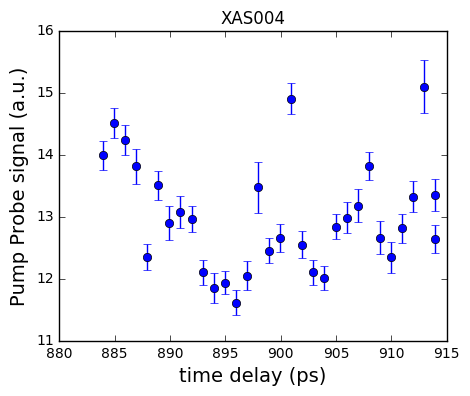

In [15]:
plt.figure(figsize=[5,4])
pp_time   = np.zeros(n_delays)
pp_signal = np.zeros(n_delays)
pp_error  = np.zeros(n_delays)
c = 299792458 #m/s

for i in range(n_delays):
    pp_time[i] = pp_delay[i,0]*1e-3/c*1e12*2
    good_shots = np.ones(n_shots)
    good_shots[i0[i]<1e1] = 0
    pp = XAS_intensity[i]/i0[i]
    pp_signal[i]  = np.average(pp[good_shots==1])
    pp_error[i]   = np.std(pp[good_shots==1])/np.sqrt(len(pp[good_shots==1]))

plt.errorbar(pp_time,pp_signal,yerr=pp_error,fmt='o')
plt.title('XAS00%d'%dataset)
plt.ylabel('Pump Probe signal (a.u.)',size=14)
plt.xlabel('time delay (ps)',size=14)
plt.savefig('/Users/fivos/Desktop/figXAS00%d.png'%dataset,dpi=300)
np.save('/Users/fivos/Desktop/pp_XAS00%d'%dataset,np.array([pp_time,pp_signal,pp_error]))
plt.show()